## Imports

In [ ]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.neighbors import NearestNeighbors
import random
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import resample
from sklearn import metrics
from sklearn import naive_bayes
import matplotlib.pyplot as plt
from IPython.display import SVG
import networkx as nx
import colorsys
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd "/content/drive/MyDrive/cs5830-final-project/data"
% ls .``

/content/drive/.shortcut-targets-by-id/1EI5BzalP4ByQ-oOEwnIRYoxXXuHKAmr7/cs5830-final-project/data
 AllStars.txt          'Copy of AllStars.txt'
 basketball_stats.csv   wikipedia_stats.csv


Jeremy's Drive

In [ ]:
% cd "/content/drive/MyDrive/School/Utah State University/Data Science Incubator/cs5830-final-project/data"
% ls

[Errno 2] No such file or directory: '/content/drive/MyDrive/School/Utah State University/Data Science Incubator/cs5830-final-project/data'
/content/drive/.shortcut-targets-by-id/1EI5BzalP4ByQ-oOEwnIRYoxXXuHKAmr7/cs5830-final-project/data
 AllStars.txt          'Copy of AllStars.txt'
 basketball_stats.csv   wikipedia_stats.csv


## Constants

In [ ]:
SAVE_FIGURES = False

RUN_CODE = False

## Pre-Analysis (Cleaning)

In [ ]:
df = pd.read_csv('basketball_stats.csv')
df.head()




,Name,PlayerId,Season,age,team_id,lg_id,pos,g,gs,mp,...,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,Udoka Azubuike,azubuud01,2020-21,21.0,UTA,NBA,C,15,0.0,57.0,...,0.800,4.0,9.0,13.0,0,1.0,4.0,3.0,9,16
1,Udoka Azubuike,azubuud01,2021-22,22.0,UTA,NBA,C,17,6.0,195.0,...,0.545,18.0,53.0,71.0,0,1.0,11.0,12.0,25,80
2,Michael Bytzura,bytzumi01,1946-47,24.0,PIT,BAA,NaN,60,NaN,NaN,...,0.500,NaN,NaN,NaN,31,NaN,NaN,NaN,108,210
3,Rastko Cvetković,cvetkra01,1995-96,25.0,DEN,NBA,C,14,0.0,48.0,...,0.000,4.0,7.0,11.0,3,2.0,1.0,3.0,11,10
4,Jerome Dyson,dysonje01,2011-12,24.0,NOH,NBA,PG,9,1.0,180.0,...,0.778,2.0,17.0,19.0,18,11.0,2.0,20.0,19,67


In [ ]:
# The vast majority of NA values are coming from fg3_pct, fg2_pct and ft_pct which we can calculate. 
# This cell will first drop this column then drop NAs then recalculate this value

stats = df.copy()

stats = stats.drop(columns=['fg3_pct'])
stats = stats.drop(columns=['fg2_pct'])
stats = stats.drop(columns=['ft_pct'])
stats = stats.dropna()

stats['fg3_pct'] = stats['fg3'] / stats['fg3a']
stats['fg2_pct'] = stats['fg2'] / stats['fg2a']
stats['ft_pct'] = stats['ft'] / stats['fta']

stats['fg3_pct'] = stats['fg3_pct'].fillna(0)
stats['fg2_pct'] = stats['fg2_pct'].fillna(0)
stats['ft_pct'] = stats['ft_pct'].fillna(0)

display(stats.shape)

# stats.isna().sum()


(21678, 32)

In [ ]:
#  This cell reads in the all stars and appends a 1 to the player if they have been in an all star game and 0 if they have not been in one
allStars = pd.read_csv('AllStars.txt')
allStars.head()

allStarPlayers = allStars.Player.unique()

stats['allStar'] = np.where(stats['Name'].isin(allStarPlayers), 1, 0)







In [ ]:
stats

,Name,PlayerId,Season,age,team_id,lg_id,pos,g,gs,mp,...,ast,stl,blk,tov,pf,pts,fg3_pct,fg2_pct,ft_pct,allStar
0,Udoka Azubuike,azubuud01,2020-21,21.0,UTA,NBA,C,15,0.0,57.0,...,0,1.0,4.0,3.0,9,16,0.000000,0.444444,0.800000,0
1,Udoka Azubuike,azubuud01,2021-22,22.0,UTA,NBA,C,17,6.0,195.0,...,0,1.0,11.0,12.0,25,80,0.000000,0.755102,0.545455,0
3,Rastko Cvetković,cvetkra01,1995-96,25.0,DEN,NBA,C,14,0.0,48.0,...,3,2.0,1.0,3.0,11,10,0.000000,0.333333,0.000000,0
4,Jerome Dyson,dysonje01,2011-12,24.0,NOH,NBA,PG,9,1.0,180.0,...,18,11.0,2.0,20.0,19,67,0.125000,0.450000,0.777778,0
21,A.J. Guyton,guytoaj01,2000-01,22.0,CHI,NBA,PG,33,8.0,630.0,...,64,9.0,5.0,24.0,35,198,0.391304,0.414634,0.833333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,Dino Radja,radjadi01,1994-95,27.0,BOS,NBA,PF,66,48.0,2147.0,...,111,60.0,86.0,159.0,232,1133,0.000000,0.490196,0.758958,0
30484,Dino Radja,radjadi01,1995-96,28.0,BOS,NBA,PF,53,52.0,1984.0,...,83,48.0,81.0,117.0,161,1043,0.000000,0.500000,0.694545,0
30485,Dino Radja,radjadi01,1996-97,29.0,BOS,NBA,C,25,25.0,874.0,...,48,23.0,48.0,70.0,76,349,0.000000,0.440828,0.718310,0
30487,Mark Radford,radfoma01,1981-82,22.0,SEA,NBA,SG,43,0.0,369.0,...,57,16.0,2.0,42.0,65,145,0.666667,0.536082,0.507246,0


# Getting to know more about the data


In [ ]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21678 entries, 0 to 30488
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      21678 non-null  object 
 1   PlayerId  21678 non-null  object 
 2   Season    21678 non-null  object 
 3   age       21678 non-null  float64
 4   team_id   21678 non-null  object 
 5   lg_id     21678 non-null  object 
 6   pos       21678 non-null  object 
 7   g         21678 non-null  int64  
 8   gs        21678 non-null  float64
 9   mp        21678 non-null  float64
 10  fg        21678 non-null  int64  
 11  fga       21678 non-null  int64  
 12  fg_pct    21678 non-null  float64
 13  fg3       21678 non-null  float64
 14  fg3a      21678 non-null  float64
 15  fg2       21678 non-null  float64
 16  fg2a      21678 non-null  float64
 17  efg_pct   21678 non-null  float64
 18  ft        21678 non-null  int64  
 19  fta       21678 non-null  int64  
 20  orb       21678 non-null  fl

In [ ]:
#total number of all start players
count=stats['allStar'].value_counts(sort=True)
# count=count.transpose
count

0    17750
1     3928
Name: allStar, dtype: int64

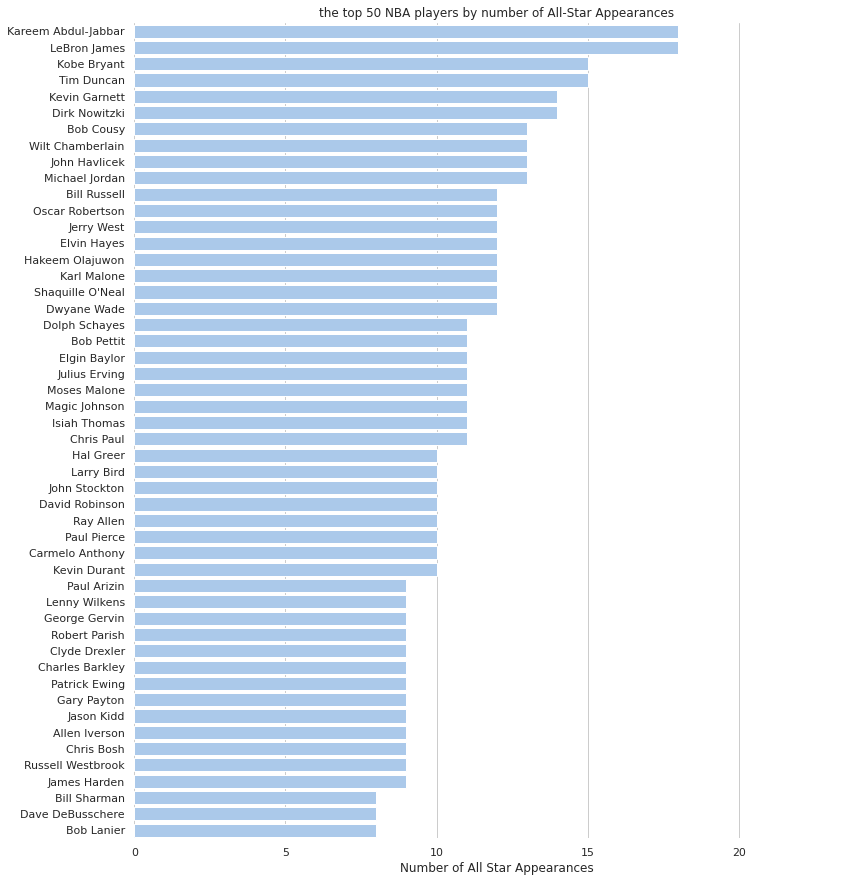

In [ ]:
#the top 50 NBA players by number of All-Star Appearances using a bar graph.
star50=allStars.head(50)
sns.set(rc={'figure.figsize':(11.7,8.27)})



sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(data=star50,x="G",y="Player", color="b")

# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=crashes,
#             label="Alcohol-involved", color="b")

# Add a legend and informative axis label
# ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Number of All Star Appearances")
ax.set(title='the top 50 NBA players by number of All-Star Appearances')
sns.despine(left=True, bottom=True)
# sns.barplot(data=allStars,x="G",y="Player")


[Text(0.5, 1.0, 'Number of All Star Players per team')]

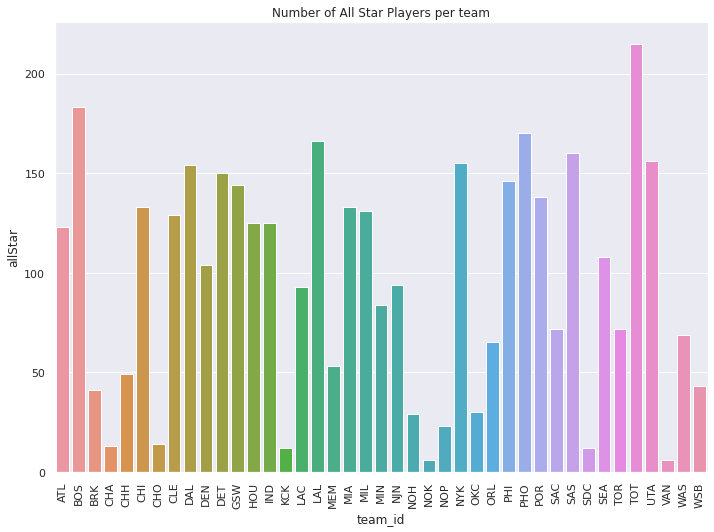

In [ ]:
grp=stats.groupby('team_id',as_index=False).sum()
sns.set(rc={'figure.figsize':(11.7,8.27)})
chart=sns.barplot(data=grp,x='team_id',y='allStar')
chart.set_xticklabels(chart.get_xticklabels(),rotation = 90)
chart.set(title='Number of All Star Players per team')

In [ ]:
allStars

,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,STL,BLK,TOV,PF,PTS,Unnamed: 25,MP.1,PTS.1,TRB.1,AST.1
0,Kareem Abdul-Jabbar,18,13,449.0,105,213,0.493,0.0,1.0,0.000,...,6.0,31.0,28.0,57,251,NaN,24.9,13.9,8.3,2.8
1,LeBron James,18,18,509.0,172,334,0.515,40.0,130.0,0.308,...,22.0,8.0,58.0,18,413,NaN,28.3,22.9,6.1,5.9
2,Kobe Bryant,15,15,415.0,119,238,0.500,22.0,68.0,0.324,...,38.0,6.0,35.0,35,290,NaN,27.7,19.3,5.0,4.7
3,Tim Duncan,15,12,311.0,63,115,0.548,1.0,4.0,0.250,...,13.0,8.0,31.0,16,140,NaN,20.7,9.3,9.1,2.1
4,Kevin Garnett,14,11,287.0,72,141,0.511,0.0,4.0,0.000,...,16.0,11.0,20.0,10,158,NaN,20.5,11.3,6.3,2.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,Darius Garland,1,0,24.0,5,12,0.417,3.0,7.0,0.429,...,2.0,0.0,1.0,0,13,NaN,23.8,13.0,1.0,3.0
434,Dejounte Murray,1,0,27.0,7,11,0.636,1.0,3.0,0.333,...,0.0,1.0,1.0,0,17,NaN,26.6,17.0,5.0,5.0
435,LaMelo Ball,1,0,22.0,7,11,0.636,4.0,8.0,0.500,...,3.0,0.0,0.0,1,18,NaN,22.4,18.0,3.0,3.0
436,Fred VanVleet,1,0,9.0,2,4,0.500,2.0,4.0,0.500,...,0.0,0.0,1.0,0,6,NaN,9.3,6.0,2.0,3.0


In [ ]:

co=allStars[['AST.1','PTS.1','TRB.1','G','MP.1']].corr()


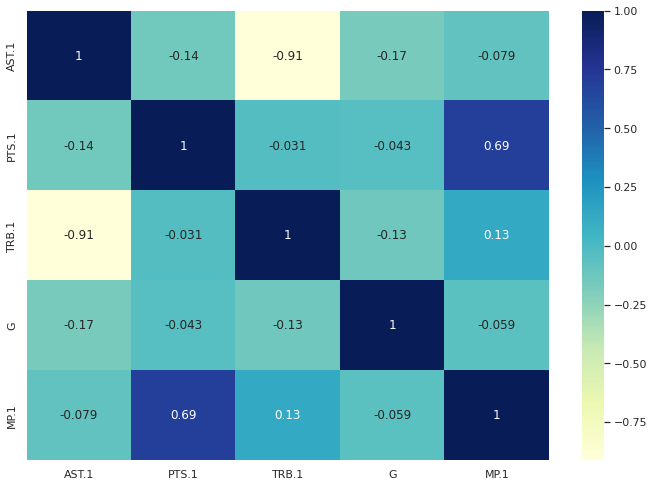

In [ ]:
sns.heatmap(co.corr(), cmap="YlGnBu", annot=True)

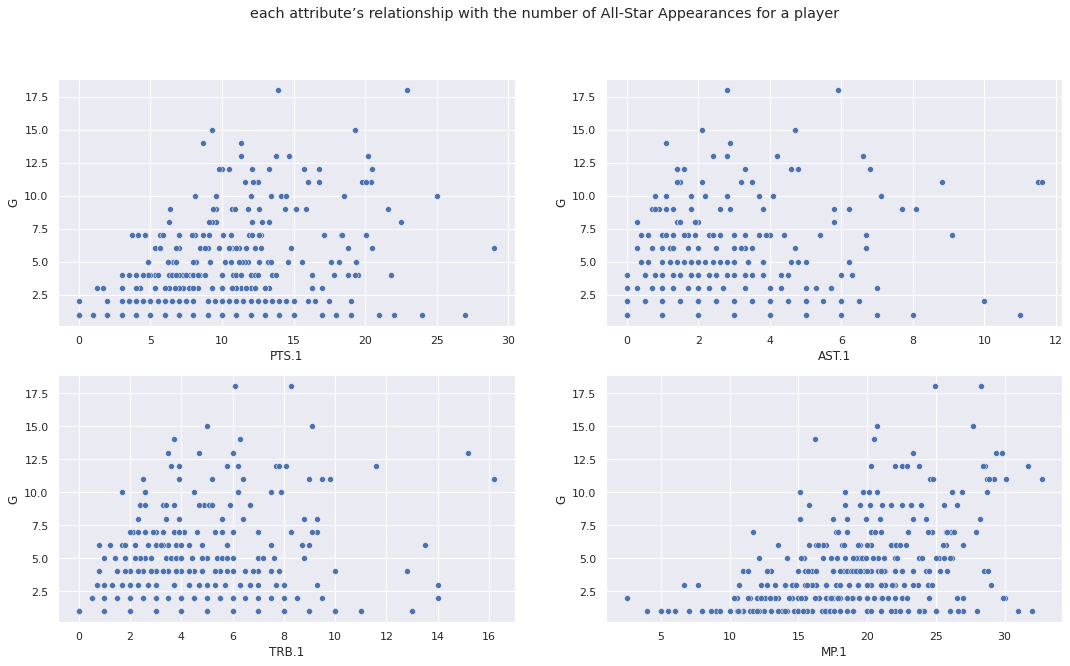

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('each attribute’s relationship with the number of All-Star Appearances for a player')

sns.scatterplot(ax=axes[0, 0], data=allStars, x='PTS.1', y='G')
sns.scatterplot(ax=axes[0, 1], data=allStars, x='AST.1', y='G')
# axes[0].set_yticklabels("All Starz")
sns.scatterplot(ax=axes[1, 0], data=allStars, x='TRB.1', y='G')
sns.scatterplot(ax=axes[1, 1], data=allStars, x='MP.1', y='G')


In [ ]:
grp=stats.groupby('Name',as_index=False).mean()
grp

,Name,age,g,gs,mp,fg,fga,fg_pct,fg3,fg3a,...,ast,stl,blk,tov,pf,pts,fg3_pct,fg2_pct,ft_pct,allStar
0,A.C. Green,29.888889,75.611111,50.277778,2169.111111,265.444444,538.111111,0.487667,6.944444,28.277778,...,81.611111,61.277778,31.222222,83.777778,143.388889,718.222222,0.146772,0.501891,0.707966,1.0
1,A.J. Bramlett,23.000000,8.000000,0.000000,61.000000,4.000000,21.000000,0.190000,0.000000,0.000000,...,0.000000,1.000000,0.000000,3.000000,13.000000,8.000000,0.000000,0.190476,0.000000,0.0
2,A.J. English,23.500000,75.500000,9.000000,1554.000000,308.500000,709.000000,0.436000,4.500000,32.500000,...,160.000000,28.500000,12.000000,101.500000,143.500000,751.000000,0.136622,0.450880,0.773958,0.0
3,A.J. Guyton,23.000000,26.666667,4.666667,415.333333,55.333333,146.666667,0.255667,24.333333,64.333333,...,49.000000,6.666667,4.000000,20.666667,19.333333,147.333333,0.255096,0.253914,0.549383,0.0
4,A.J. Hammons,24.000000,22.000000,0.000000,163.000000,17.000000,42.000000,0.405000,5.000000,10.000000,...,4.000000,1.000000,13.000000,10.000000,21.000000,48.000000,0.500000,0.375000,0.450000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3262,Šarūnas Marčiulionis,28.428571,51.857143,4.285714,1160.428571,224.428571,444.142857,0.486000,18.142857,49.142857,...,115.285714,65.571429,4.428571,102.142857,138.714286,661.571429,0.299955,0.499704,0.767411,0.0
3263,Žan Tabak,26.875000,38.000000,13.000000,573.875000,84.875000,170.750000,0.481375,0.000000,0.500000,...,26.625000,10.625000,20.500000,41.250000,92.500000,192.500000,0.000000,0.482953,0.520509,0.0
3264,Žarko Paspalj,23.000000,28.000000,1.000000,181.000000,27.000000,79.000000,0.342000,0.000000,1.000000,...,10.000000,3.000000,7.000000,21.000000,37.000000,72.000000,0.000000,0.346154,0.818182,0.0
3265,Žarko Čabarkapa,23.000000,38.000000,0.800000,405.000000,64.000000,145.000000,0.467000,7.400000,24.800000,...,22.000000,8.600000,6.000000,29.800000,56.000000,175.600000,0.231944,0.492245,0.800510,0.0


# Pre-Analysis (Original models)

In [ ]:
grp.columns


Index(['Name', 'age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a',
       'fg2', 'fg2a', 'efg_pct', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', 'fg3_pct', 'fg2_pct', 'ft_pct',
       'allStar'],
      dtype='object')

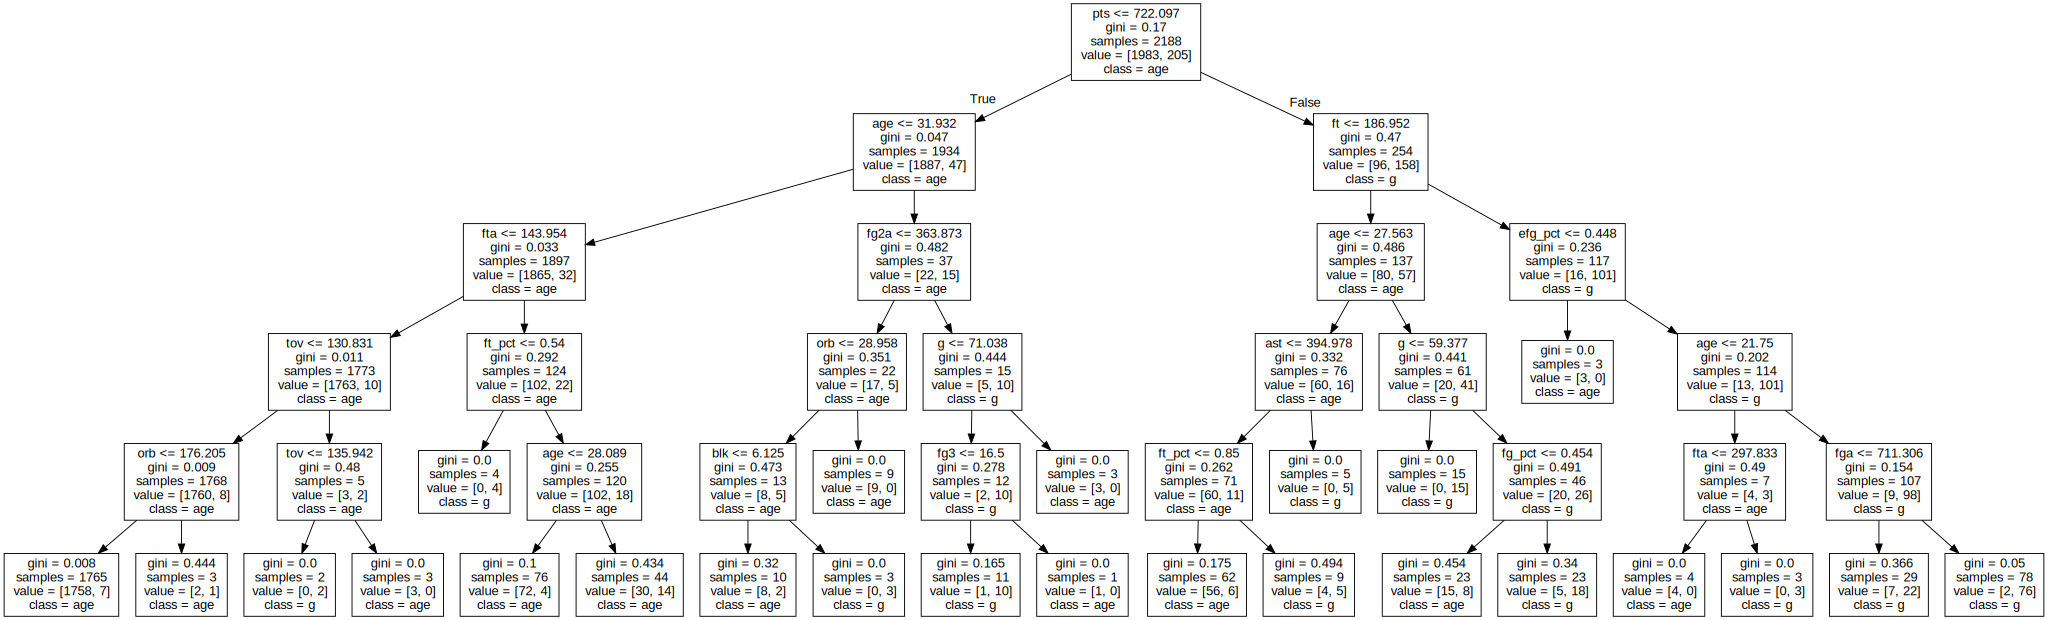

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       981
         1.0       0.75      0.65      0.70        98

    accuracy                           0.95      1079
   macro avg       0.86      0.82      0.84      1079
weighted avg       0.95      0.95      0.95      1079

[[960  21]
 [ 34  64]]
Accuracy:  0.9490268767377201


<Figure size 1800x1440 with 0 Axes>

In [ ]:
feature_cols=['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a',
       'fg2', 'fg2a', 'efg_pct', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', 'fg3_pct', 'fg2_pct', 'ft_pct']
X = grp[feature_cols] 
y = grp.allStar

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)
treeclf = treeclf.fit(X_train, y_train)

# plt.figure(figsize=(120,10))

# tree.plot_tree(treeclf)
fig = plt.figure(figsize=(25,20))
# graph = tree.plot_tree(treeclf, 
#                    feature_names=feature_cols,  
#                    class_names=['1','2'],
                  #  filled=True)
graph =Source(tree.export_graphviz(treeclf, out_file=None, feature_names=feature_cols, class_names=['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a',
       'fg2', 'fg2a', 'efg_pct', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', 'fg3_pct', 'fg2_pct', 'ft_pct']))


display(graph)

y_pred = treeclf.predict(X_test)



expectedValue  = y_test
predictedValue = treeclf.predict(X_test)


# metrics are used to find accuracy or error

print(metrics.classification_report(expectedValue, predictedValue))
print(metrics.confusion_matrix(expectedValue, predictedValue))

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))


In [ ]:
xSet = grp.drop(columns=['Name','g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a',
       'fg2', 'fg2a', 'efg_pct', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov'])
ySet = grp['allStar']

xSet_train, xSet_test, ySet_train, ySet_test = train_test_split(xSet, ySet)

model = naive_bayes.GaussianNB()
model.fit(xSet_train, ySet_train)


expectedValue  = ySet_test
predictedValue = model.predict(xSet_test)

print(metrics.classification_report(expectedValue, predictedValue))
print(metrics.confusion_matrix(expectedValue, predictedValue))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       755
         1.0       1.00      1.00      1.00        62

    accuracy                           1.00       817
   macro avg       1.00      1.00      1.00       817
weighted avg       1.00      1.00      1.00       817

[[755   0]
 [  0  62]]


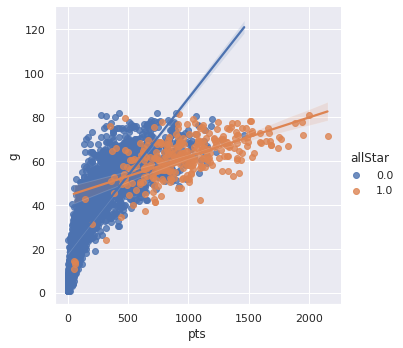

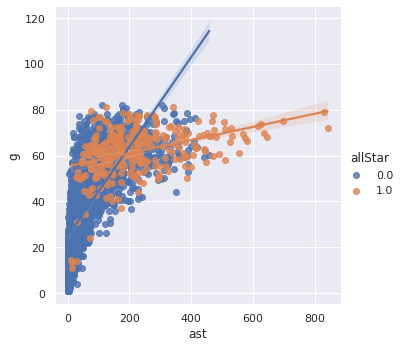

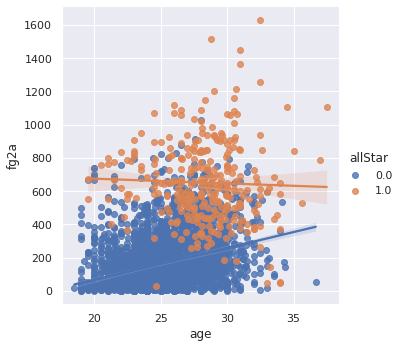

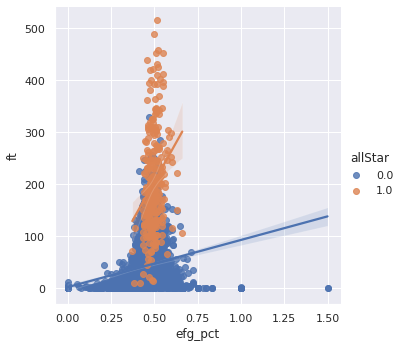

In [ ]:


sns.lmplot(hue="allStar",data=grp, x='pts', y='g')
sns.lmplot( data=grp,hue="allStar", x='ast', y='g')
# axes[0].set_yticklabels("All Starz")
sns.lmplot(data=grp,hue="allStar", x='age', y='fg2a')
sns.lmplot( data=grp,hue="allStar", x='efg_pct', y='ft')

In [ ]:
#Linear Regression
feature_cols=['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a',
       'fg2', 'fg2a', 'efg_pct', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', 'fg3_pct', 'fg2_pct', 'ft_pct']
X = grp[feature_cols] 
y = grp.allStar

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
regr = LinearRegression()
  
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# plt.scatter(X_test, y_test, color ='b')
# plt.plot(X_test, y_pred, color ='k')
expectedValue  = y_test
predictedValue = regr.predict(X_test)

# create a fitted model with all three features
lm = smf.ols(formula='allStar ~ age + g + fg2a + efg_pct + ft + ast + pts + fg3_pct + ft_pct', data=grp).fit()

# print the coefficients
display(lm.params)

# print a summary of the fitted model
lm.summary()


Intercept   -0.279592
age          0.012989
g           -0.005671
fg2a         0.000294
efg_pct      0.061163
ft           0.001622
ast          0.000391
pts          0.000215
fg3_pct     -0.057387
ft_pct      -0.008302
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                allStar   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     391.9
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:25:57   Log-Likelihood:                 606.25
No. Observations:                3267   AIC:                            -1192.
Df Residuals:                    3257   BIC:                            -1132.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2796      0.036     -7.672      0.000      -0.351      -0.208
age            0.0130      0.001      9.526      0.000       0.010       0.016
g             -0.0057      0.000    -18.702      0.000      -0.006      -0.005
fg2a           0.0003   6.05e-05      4.863      0.000       0.000       0.000
efg_pct        0.0612      0.034      1.778      0.076      -0.006       0.129
ft             0.0016      0.000     10.082      0.000       0.001       0.002
ast            0.0004   5.99e-05      6.521      0.000       0.000       0.001
pts            0.0002   5.27e-05      4.069      0.000       0.000       0.000
fg3_pct       -0.0574      0.027     -2.089      0.037      -0.111      -0.004
ft_pct        -0.0083      0.020     -0.419      0.676      -0.047       0.031
==============================================================================
Omnibus:                      890.924   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3816.238
Skew:                           1.265   Prob(JB):                         0.00
Kurtosis:                       7.651   Cond. No.                     6.64e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#Random Forest Classifier
feature_cols=['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_pct', 'fg3', 'fg3a',
       'fg2', 'fg2a', 'efg_pct', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', 'fg3_pct', 'fg2_pct', 'ft_pct']
X = grp[feature_cols] 
y = grp.allStar

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 

expectedValue  = y_test
predictedValue = clf.predict(X_test)


# metrics are used to find accuracy or error
from sklearn import metrics 
print()
print(metrics.classification_report(expectedValue, predictedValue))
print(metrics.confusion_matrix(expectedValue, predictedValue))
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       981
         1.0       0.78      0.68      0.73        98

    accuracy                           0.95      1079
   macro avg       0.87      0.83      0.85      1079
weighted avg       0.95      0.95      0.95      1079

[[962  19]
 [ 31  67]]
ACCURACY OF THE MODEL:  0.953660797034291


# Analysis (Final Models)

## NN

In [ ]:
# stats.head

In [ ]:
wiki = pd.read_csv("wikipedia_stats.csv")

combined = pd.merge(stats, wiki)
combined.head()

allwiki = combined[['allStar','avgvisitslast30days']]




In [ ]:


# Change stats or combined for with or without
# X = stats.drop(['allStar'], axis=1)
# X = combined.drop(['allStar'], axis=1)
X = allwiki.drop(['allStar'], axis=1)





# X = X.drop(['Name'], axis=1)
# X = X.drop(['PlayerId'], axis=1)
# X = X.drop(['Season'], axis=1)
# X = X.drop(['team_id'], axis=1)
# X = X.drop(['lg_id'], axis=1)
# X = X.drop(['pos'], axis=1)

feature_cols = []
for (columnName, columnData) in X.iteritems():
     if (columnName != "CLASS"):
       feature_cols.append(columnName)




y = stats["allStar"]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

# X_best = SelectKBest(chi2, k=5).fit(X, y).get_feature_names_out(feature_cols)
# X_new = X[X_best]

In [ ]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)

mlp.fit(X_train,y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

[[4303  135]
 [ 672  310]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4438
           1       0.70      0.32      0.43       982

    accuracy                           0.85      5420
   macro avg       0.78      0.64      0.67      5420
weighted avg       0.83      0.85      0.83      5420



# Popularity - Logistic Regression Model

In [ ]:
df_wiki = pd.read_csv("./wikipedia_stats.csv")

df_wiki.head()

,Name,avgvisitslast30days
0,Udoka Azubuike,511.833333
1,Michael Bytzura,1.375000
2,Rastko Cvetković,9.533333
3,Jerome Dyson,27.033333
4,Johnny Ezersky,7.000000


In [ ]:
df_groupByName = stats.groupby("Name").agg(allStar=('allStar', 'mean'))

df_popular = pd.merge(df_wiki, df_groupByName, on="Name")

df_popular.drop(df_popular[df_popular.avgvisitslast30days < 0].index, inplace=True)

df_popular.head()

,Name,avgvisitslast30days,allStar
0,Udoka Azubuike,511.833333,0.0
1,Rastko Cvetković,9.533333,0.0
2,Jerome Dyson,27.033333,0.0
3,A.J. Guyton,7.033333,0.0
4,Bones Hyland,1139.500000,0.0


In [ ]:
P_train, P_test, T_train, T_test = train_test_split(df_popular['avgvisitslast30days'], df_popular['allStar'], test_size=.25, random_state=42)

lm = LogisticRegression()
lm.fit(np.array(P_train).reshape(-1,1), np.array(T_train).reshape(-1,1))

print("Intercept: {}\nCoefficient: {}".format(lm.intercept_, lm.coef_))

lm_pred = lm.predict(np.array(P_test).reshape(-1,1))

print(classification_report(np.array(T_test).reshape(-1,1), lm_pred))

Intercept: [-2.77288135]
Coefficient: [[0.00099974]]
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       742
         1.0       0.65      0.15      0.24        73

    accuracy                           0.92       815
   macro avg       0.78      0.57      0.60       815
weighted avg       0.90      0.92      0.89       815



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
